# KDDCUP results

In [ ]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline


def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def time(expr):
    start = datetime.datetime.now()
    code = eval(expr)
    end = datetime.datetime.now()
    return (end-start, code)

sa_columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                           "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                           "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                           "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
sf_columns = ["duration", "service", "src_bytes", "dst_bytes"]

# Trainning IF

# Loading dataset and setup parameters

In [ ]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=True, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
f"SF anomaly rate is {anomaly_rate_sf:.1%}"

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=0)

In [ ]:
parameters = {'contamination':[0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]}
# If = GridSearchCV(IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100), param_grid = parameters, scoring = make_scorer(precision_score), refit=True)
# If.fit(X_train_sf, y_train_sf)

# Manual cross-validation search for contamination on smaller dataset


In [ ]:
for c in parameters['contamination']:
  y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(X_train_sf).predict(X_test_sf)
  print(classification_report(y_test_sf, y_pred))
  print(f"AUC : {roc_auc_score(y_test_sf, y_pred):.1}")

              precision    recall  f1-score   support

          -1       0.15      0.17      0.16       836
           1       0.96      0.95      0.96     17474

    accuracy                           0.92     18310
   macro avg       0.55      0.56      0.56     18310
weighted avg       0.92      0.92      0.92     18310

AUC : 0.6
              precision    recall  f1-score   support

          -1       0.08      0.18      0.11       836
           1       0.96      0.90      0.93     17474

    accuracy                           0.87     18310
   macro avg       0.52      0.54      0.52     18310
weighted avg       0.92      0.87      0.89     18310

AUC : 0.5
              precision    recall  f1-score   support

          -1       0.07      0.18      0.10       836
           1       0.96      0.89      0.92     17474

    accuracy                           0.86     18310
   macro avg       0.51      0.53      0.51     18310
weighted avg       0.92      0.86      0.88     18310


In [ ]:
contamination = [round(0.1 + 0.01*i, 2) for i in range(30)]
for c in contamination:
  y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(X_train_sf).predict(X_test_sf)
  # print(classification_report(y_test_sf, y_pred))
  p, r, f, s = precision_recall_fscore_support(y_test_sf, y_pred, labels=[-1])
  fp = s / p - s
  print(f"contamination: {c}, AUC : {roc_auc_score(y_test_sf, y_pred):.1}, precision: {round(p[0], 2)}, support: {s}, recall: {round(r[0], 2)}, fp: {round(fp[0], 0)}")

contamination: 0.1, AUC : 0.5, precision: 0.08, support: [836], recall: 0.18, fp: 9693.0
contamination: 0.11, AUC : 0.5, precision: 0.07, support: [836], recall: 0.18, fp: 10953.0
contamination: 0.12, AUC : 0.5, precision: 0.07, support: [836], recall: 0.18, fp: 11806.0
contamination: 0.13, AUC : 0.6, precision: 0.12, support: [836], recall: 0.35, fp: 6091.0
contamination: 0.14, AUC : 0.6, precision: 0.11, support: [836], recall: 0.35, fp: 6603.0
contamination: 0.15, AUC : 0.6, precision: 0.1, support: [836], recall: 0.35, fp: 7171.0
contamination: 0.16, AUC : 0.6, precision: 0.1, support: [836], recall: 0.35, fp: 7678.0
contamination: 0.17, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8229.0
contamination: 0.18, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.19, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contaminatio

In [ ]:
contamination = [round(0.2 + 0.001*i, 3) for i in range(11)]
for c in contamination:
  y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(X_train_sf).predict(X_test_sf)
  # print(classification_report(y_test_sf, y_pred))
  p, r, f, s = precision_recall_fscore_support(y_test_sf, y_pred, labels=[-1])
  fp = s / p - s
  print(f"contamination: {c}, AUC : {roc_auc_score(y_test_sf, y_pred):.1}, precision: {round(p[0], 2)}, support: {s}, recall: {round(r[0], 2)}, fp: {round(fp[0], 0)}")

contamination: 0.2, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.201, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.202, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.203, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.204, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3020.0
contamination: 0.205, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3041.0
contamination: 0.206, AUC : 0.9, precision: 0.21, support: [836], recall: 1.0, fp: 3067.0
contamination: 0.207, AUC : 0.9, precision: 0.21, support: [836], recall: 1.0, fp: 3087.0
contamination: 0.208, AUC : 0.9, precision: 0.21, support: [836], recall: 1.0, fp: 3113.0
contamination: 0.209, AUC : 0.9, precision: 0.21, support: [836], recall: 1.0, fp: 3131.0
contamination: 0.21, AUC : 0.9, precision: 0.21, support: [836], recall: 1.0, fp: 3154.0


In [ ]:
contamination = [round(0.201 + 0.0001*i, 4) for i in range(11)]
for c in contamination:
  y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(X_train_sf).predict(X_test_sf)
  # print(classification_report(y_test_sf, y_pred))
  p, r, f, s = precision_recall_fscore_support(y_test_sf, y_pred, labels=[-1])
  fp = s / p - s
  print(f"contamination: {c}, AUC : {roc_auc_score(y_test_sf, y_pred):.1}, precision: {round(p[0], 2)}, support: {s}, recall: {round(r[0], 2)}, fp: {round(fp[0], 0)}")

contamination: 0.201, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2011, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2012, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.2013, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2014, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2015, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2016, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.2017, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2018, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.2019, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.202, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3

In [ ]:
contamination = [round(0.2011 + 0.00001*i, 5) for i in range(11)]
for c in contamination:
  y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(X_train_sf).predict(X_test_sf)
  # print(classification_report(y_test_sf, y_pred))
  p, r, f, s = precision_recall_fscore_support(y_test_sf, y_pred, labels=[-1])
  fp = s / p - s
  print(f"contamination: {c}, AUC : {roc_auc_score(y_test_sf, y_pred):.1}, precision: {round(p[0], 2)}, support: {s}, recall: {round(r[0], 2)}, fp: {round(fp[0], 0)}")

contamination: 0.2011, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.20111, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.20112, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.20113, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.20114, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.20115, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.20116, AUC : 0.9, precision: 0.22, support: [836], recall: 1.0, fp: 3009.0
contamination: 0.20117, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.20118, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.20119, AUC : 0.6, precision: 0.09, support: [836], recall: 0.35, fp: 8556.0
contamination: 0.2012, AUC : 0.9, precision: 0.22, support: [836], recall:

In [ ]:
If.cv_results_

{'mean_fit_time': array([2.90855026, 2.67303553, 2.63002954, 2.63448086, 2.67360396,
        2.68544455, 2.64424467, 2.63690939, 2.63578124, 2.60190864,
        2.58971887, 2.59002118]),
 'mean_score_time': array([0.63267727, 0.60461512, 0.6016675 , 0.58049212, 0.61961908,
        0.60819039, 0.66821408, 0.52835064, 0.49928179, 0.55175858,
        0.47246799, 0.46751328]),
 'mean_test_score': array([0.96199859, 0.96047053, 0.96007857, 0.96164138, 0.96291305,
        0.96720783, 0.96681218, 0.96647507, 0.97276371, 0.97268091,
        0.98599401, 0.99310116]),
 'param_contamination': masked_array(data=[0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
                    0.18, 0.19, 0.2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'contamination': 0.05},
  {'contamination': 0.1},
  {'contamination': 0.11},
  {'contamination': 0.12},
  {'con

# Results of cross-validation search

              precision    recall  f1-score   support

          -1       0.22      1.00      0.36       836
           1       1.00      0.83      0.91     17474

    accuracy                           0.84     18310
   macro avg       0.61      0.91      0.63     18310
weighted avg       0.96      0.84      0.88     18310



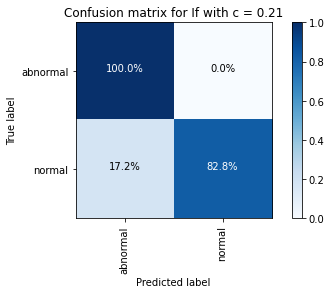

In [ ]:
oIf = IsolationForest(contamination=0.20112, max_samples=0.25, n_estimators=100, n_jobs=-1, random_state=1)
Y_pred_if = oIf.fit(X_train_sf).predict(X_test_sf)
cm_if = confusion_matrix(y_test_sf, Y_pred_if)
print(classification_report(y_test_sf, Y_pred_if))
plot_confusion_matrix(cm_if, "Confusion matrix for If with c = 0.20112")

# Load big dataset and setup parameters

In [ ]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=False, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
f"SF anomaly rate is {anomaly_rate_sf:.1%}"

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=0)

# Manual cross-validation search with bigger dataset


# Isolation Forest

In [ ]:
def cross-validation(contamination):
  highest_score = 0
  highest_score_c = 0
  for c in contamination:
    y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(X_train_sf).predict(X_test_sf)
    # print(classification_report(y_test_sf, y_pred))
    p, r, f, s = precision_recall_fscore_support(y_test_sf, y_pred, labels=[-1])
    if p > highest_score: p = highest_score; highest_score_c = c
    fp = s / p - s
    print(f"contamination: {c}, AUC : {roc_auc_score(y_test_sf, y_pred):.1}, precision: {round(p[0], 2)}, support: {s}, recall: {round(r[0], 2)}, fp: {round(fp[0], 0)}")
    return c

# Exhaustive search range, big margin

In [ ]:
contamination = [round(0.1 + 0.01*i, 2) for i in range(31)]
c_max = cross-validation(contamination)

# Narrowing search range, smaller margin

In [ ]:
contamination = [round(c_max + 0.001*i, 3) for i in range(11)]
c_max = cross-validation(contamination)

# Precision search range, smallest margin

In [ ]:
contamination = [round(c_max + 0.0001*i, 4) for i in range(11)]
c_max = cross-validation(contamination)

# Limit testing, tiny margin

In [ ]:
contamination = [round(c_max + 0.000001*i, 5) for i in range(11)]
c_max = cross-validation(contamination)